In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sn


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


**1: Pre-processing**

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv') 
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [4]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
train.isna().sum().sum() # проверим есть ли где NaN

0

In [7]:
train['label'].unique()  

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [8]:
train_set, val_set = train_test_split(train, test_size = 0.2, random_state  = 49)

<AxesSubplot:>

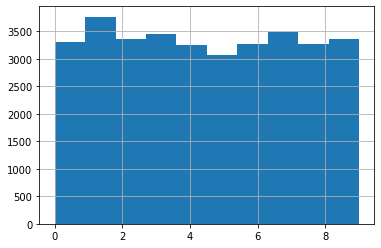

In [9]:
train_set.label.hist()

<AxesSubplot:>

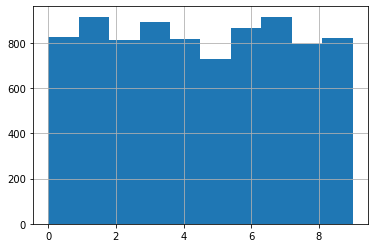

In [10]:
val_set.label.hist()
#примерно одинаковое распределение

In [11]:
#создаём X(train_set) и Y(train_labels)
train_labels = train_set['label'].copy()
train_labels = train_labels.to_numpy()
train_set.drop('label', axis = 1, inplace = True)
val_labels = val_set['label'].copy()
val_labels = val_labels.to_numpy()
val_set.drop('label', axis = 1, inplace = True)

In [12]:
# стандартизацируем данные, приводим их в значения от 0 до 1 
train_set = train_set.to_numpy() / 255
val_set = val_set.to_numpy() / 255
test_set = test.to_numpy() / 255

# из вектора в картинку
image_shape = (28, 28, 1)
train_set = np.reshape(train_set, (train_set.shape[0], *image_shape))
val_set = np.reshape(val_set, (val_set.shape[0], *image_shape))
test_set = np.reshape(test_set, (test.shape[0], *image_shape))

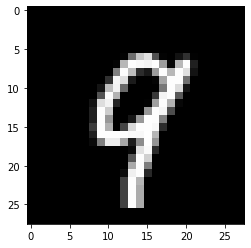

In [13]:
plt.imshow(train_set[0], cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

**2: Создаём и оцениваем модель**

In [14]:
# Пробывал это модель на Fashion MNISTе (датасет чёрно-белых фото одежды), работала хорошо
cnn_model = keras.models.Sequential()
cnn_model.add(keras.layers.Conv2D(64, 7, activation = 'relu', padding = 'same', 
                                  input_shape = image_shape))
cnn_model.add(keras.layers.MaxPooling2D(2))
cnn_model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
cnn_model.add(keras.layers.MaxPooling2D(2))
cnn_model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
cnn_model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
cnn_model.add(keras.layers.MaxPooling2D(2))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(128, activation = 'relu'))
cnn_model.add(keras.layers.Dropout(0.5))
cnn_model.add(keras.layers.Dense(64, activation = 'relu'))
cnn_model.add(keras.layers.Dropout(0.5))
cnn_model.add(keras.layers.Dense(10, activation = 'softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

2022-07-03 20:07:39.936165: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
cnn_model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(1e-3), 
                  metrics = ['accuracy'])

In [16]:
history = cnn_model.fit(train_set, train_labels, batch_size = 96, 
                        epochs = 5, validation_data = (val_set, val_labels))

2022-07-03 20:07:40.523979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
350/350 [==============================] - 187s 533ms/step - loss: 0.6912 - accuracy: 0.7717 - val_loss: 0.0856 - val_accuracy: 0.9799
Epoch 2/5
350/350 [==============================] - 187s 534ms/step - loss: 0.1822 - accuracy: 0.9512 - val_loss: 0.0827 - val_accuracy: 0.9802
Epoch 3/5
350/350 [==============================] - 187s 535ms/step - loss: 0.1199 - accuracy: 0.9705 - val_loss: 0.0601 - val_accuracy: 0.9888
Epoch 4/5
350/350 [==============================] - 186s 533ms/step - loss: 0.1021 - accuracy: 0.9759 - val_loss: 0.0485 - val_accuracy: 0.9900
Epoch 5/5
350/350 [==============================] - 188s 538ms/step - loss: 0.0743 - accuracy: 0.9822 - val_loss: 0.0479 - val_accuracy: 0.9882


In [17]:
#посмотрим на матрицу несоответствий 
y_val_proba = cnn_model.predict(val_set)
y_val_proba = np.argmax(y_val_proba, axis = 1)
conf_matrix = confusion_matrix(val_labels, y_val_proba)
conf_matrix

array([[825,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 911,   1,   0,   2,   0,   0,   2,   0,   0],
       [  0,   2, 807,   0,   0,   0,   1,   2,   2,   0],
       [  0,   0,   3, 880,   0,   4,   0,   2,   5,   1],
       [  1,   3,   1,   0, 795,   0,   2,   3,   1,  13],
       [  1,   0,   0,   1,   0, 724,   2,   0,   2,   0],
       [  1,   0,   0,   0,   0,   0, 863,   0,   1,   0],
       [  0,   1,  14,   1,   3,   0,   0, 894,   1,   3],
       [  0,   0,   1,   0,   0,   1,   3,   0, 787,   2],
       [  1,   0,   0,   0,   1,   2,   0,   1,   4, 815]])

<AxesSubplot:>

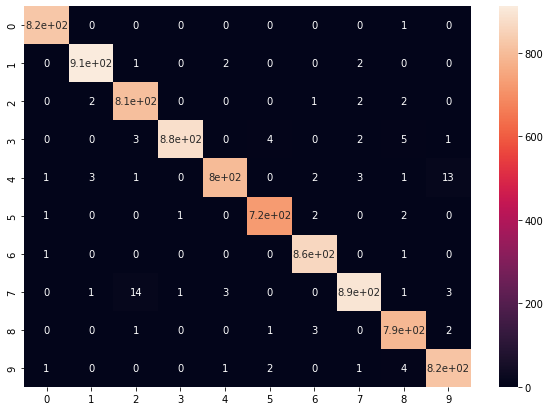

In [18]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [19]:
test_pred = cnn_model.predict(test_set)
test_pred = np.argmax(test_pred, axis = 1)

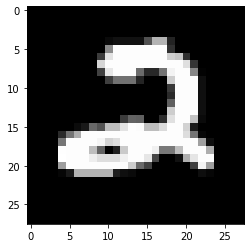

In [20]:
plt.imshow(test_set[0], cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

In [21]:
test_pred[0]

2

In [22]:
sub = pd.DataFrame({'ImageId' : range(1, len(test_pred) + 1),'Label' : test_pred})
sub.to_csv('submission.csv',  index = False)
print(sub.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
